In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu, chi2_contingency, ttest_ind

# automated feature engineering
import featuretools as ft

# Filter out pandas warnings
import warnings

warnings.filterwarnings("ignore")

start = "\033[1m"  # Bold text
end = "\033[0;0m"  # Reset text
from IPython.core.interactiveshell import InteractiveShell
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
import time
from lightgbm import LGBMClassifier
import lightgbm as lgb

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

%matplotlib inline

import warnings

warnings.simplefilter("ignore", UserWarning)

warnings.filterwarnings("ignore")

InteractiveShell.ast_node_interactivity = "all"

import sys

sys.path.append("../")
from helpers import *

In [6]:
pd.options.display.max_rows, pd.options.display.max_columns

# https://thispointer.com/python-pandas-how-to-display-full-dataframe-i-e-print-all-rows-columns-without-truncation/
# Print all the contents of a pandas dataframe
pd.set_option(
    "display.max_rows", None
)  # Print unlimited number of rows by setting to None, default is 10
pd.set_option(
    "display.max_columns", None
)  # Do not truncate columns to display all of them by setting to None
pd.set_option(
    "display.width", None
)  # Auto-detect the width of dataframe to display all columns in single line by setting to None
pd.set_option(
    "display.max_colwidth", None
)  # Auto detect the max size of column and print contents of that column without truncation

(60, 20)

In [7]:
X_train = pd.read_csv("../training_data/X_train.csv")
X_test = pd.read_csv("../training_data/X_test.csv")
y_train = pd.read_csv("../training_data/y_train.csv")
y_test = pd.read_csv("../training_data/y_test.csv")

In [8]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((230633, 512), (76878, 512), (230633, 1), (76878, 1))

## Baseline Models

In [10]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, classification_report, accuracy_score
from sklearn.ensemble import (
    RandomForestClassifier,
    ExtraTreesClassifier,
    GradientBoostingClassifier,
    AdaBoostClassifier,
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, classification_report, accuracy_score
import pandas as pd
from sklearn.impute import SimpleImputer
from catboost import CatBoostClassifier


def evaluate_model(
    model, model_params, X_train, y_train, X_test, y_test, use_early_stopping=False
):
    # Adjust model with provided parameters
    model.set_params(**model_params)

    # Impute missing values
    imputer = SimpleImputer(strategy="mean")
    X_train_imputed = imputer.fit_transform(X_train)
    X_test_imputed = imputer.transform(X_test)

    # Check if the model supports early stopping
    if (
        use_early_stopping
        and hasattr(model, "fit")
        and "early_stopping_rounds" in model.get_params()
    ):
        model.fit(
            X_train_imputed,
            y_train,
            eval_set=[(X_test_imputed, y_test)],
            early_stopping_rounds=100,
            verbose=False,
        )
    else:
        model.fit(X_train_imputed, y_train)

    # Predictions
    y_pred = model.predict(X_test_imputed)
    y_pred_proba = (
        model.predict_proba(X_test_imputed)[:, 1]
        if hasattr(model, "predict_proba")
        else None
    )

    # Calculate metrics
    auc_score = (
        roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None
    )
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)

    # Convert the classification report into a DataFrame
    metrics_df = pd.DataFrame(report).transpose()

    # Add accuracy and potentially AUC to the DataFrame
    metrics_df.loc["Accuracy", "precision"] = accuracy
    if auc_score is not None:
        metrics_df.loc["AUC", "precision"] = auc_score
        metrics_df.loc["AUC", ["recall", "f1-score"]] = (
            np.nan
        )  # Set non-applicable columns as NaN

    # Add the model name in the df
    metrics_df["model"] = model.__class__.__name__

    return metrics_df

In [11]:
# Correctly sampling the data
# X_train_sample = X_train.sample(50000, random_state=50)
# y_train_sample = y_train.loc[X_train_sample.index]  # Ensure the indices match

# X_test_sample = X_test.sample(50000, random_state=50)
# y_test_sample = y_test.loc[X_test_sample.index]  # Ensure the indices match


import time

start = time.time()
xgb_params = {"tree_method": "gpu_hist"}
xgb_metrics_df = evaluate_model(
    XGBClassifier(random_state=50), xgb_params, X_train, y_train, X_test, y_test
)
end = time.time()
print("[XGB] Time taken in seconds: ", end - start)

# RandomForestClassifier using 8 cores
start = time.time()
rf_params = {"n_jobs": -1}
rf_metrics_df = evaluate_model(
    RandomForestClassifier(random_state=50), rf_params, X_train, y_train, X_test, y_test
)
end = time.time()
print("[RF] Time taken in seconds: ", end - start)

# LightGBM
start = time.time()
lgb_params = {
    "objective": "binary",
    "metric": "auc",
    "seed": 50,
    "verbose": -1,
    "n_jobs": -1,
}
lgb_metrics_df = evaluate_model(
    lgb.LGBMClassifier(), lgb_params, X_train, y_train, X_test, y_test
)
end = time.time()
print("[LGBM] Time taken in seconds: ", end - start)

# CART (Decision Tree)
start = time.time()
cart_metrics_df = evaluate_model(
    DecisionTreeClassifier(random_state=50),
    {"n_jobs": -1},
    X_train,
    y_train,
    X_test,
    y_test,
)
end = time.time()
print("[CART] Time taken in seconds: ", end - start)

# Extra Trees
start = time.time()
et_metrics_df = evaluate_model(
    ExtraTreesClassifier(random_state=50),
    {"n_jobs": -1},
    X_train,
    y_train,
    X_test,
    y_test,
)
end = time.time()
print("[ExtraTrees] Time taken in seconds: ", end - start)

# CatBoost
start = time.time()
catboost_params = {
    "task_type": "GPU",
    "devices": "0",  # Specifies the GPU ID to use. For multiple GPUs, use '0:1:2' for GPUs 0, 1, and 2, for example.
    "random_seed": 50,
    "silent": True,
}

# Evaluate CatBoost model
catboost_metrics_df = evaluate_model(
    CatBoostClassifier(), catboost_params, X_train, y_train, X_test, y_test
)
end = time.time()
print("[CB] Time taken in seconds: ", end - start)

# adaboost
start = time.time()
ada_metrics_df = evaluate_model(
    AdaBoostClassifier(random_state=50),
    {"n_jobs": -1},
    X_train,
    y_train,
    X_test,
    y_test,
)
end = time.time()
print("[ADA] Time taken in seconds: ", end - start)

# ID3
start = time.time()
dt_params = {"criterion": "entropy", "random_state": 50, "n_jobs": -1}
id3_metrics_df = evaluate_model(
    DecisionTreeClassifier(), dt_params, X_train, y_train, X_test, y_test
)
end = time.time()
print("[ID3] Time taken in seconds: ", end - start)
print(id3_metrics_df)

xgb_metrics_df
rf_metrics_df
lgb_metrics_df
catboost_metrics_df
et_metrics_df
cart_metrics_df
ada_metrics_df
id3_metrics_df

[XGB] Time taken in seconds:  5.499943256378174
[RF] Time taken in seconds:  34.26265788078308
[LGBM] Time taken in seconds:  8.094448804855347
[CART] Time taken in seconds:  157.02120685577393
[ExtraTrees] Time taken in seconds:  104.15846180915833
[CB] Time taken in seconds:  13.925080299377441
[ADA] Time taken in seconds:  198.02703022956848
[ID3] Time taken in seconds:  78.51158237457275
              precision    recall  f1-score       support  \
0              0.926870  0.918740  0.922787  70687.000000   
1              0.156658  0.172347  0.164129   6191.000000   
accuracy       0.858633  0.858633  0.858633      0.858633   
macro avg      0.541764  0.545544  0.543458  76878.000000   
weighted avg   0.864845  0.858633  0.861692  76878.000000   
Accuracy       0.858633       NaN       NaN           NaN   
AUC            0.545544       NaN       NaN           NaN   

                               model  
0             DecisionTreeClassifier  
1             DecisionTreeClassifier  

,precision,recall,f1-score,support,model
0,0.923863,0.993747,0.957532,70687.00000,XGBClassifier
1,0.476303,0.064933,0.114286,6191.00000,XGBClassifier
accuracy,0.918950,0.918950,0.918950,0.91895,XGBClassifier
macro avg,0.700083,0.529340,0.535909,76878.00000,XGBClassifier
weighted avg,0.887821,0.918950,0.889625,76878.00000,XGBClassifier
Accuracy,0.918950,NaN,NaN,NaN,XGBClassifier
AUC,0.770874,NaN,NaN,NaN,XGBClassifier


,precision,recall,f1-score,support,model
0,0.919852,0.999505,0.958026,70687.00000,RandomForestClassifier
1,0.500000,0.005653,0.011180,6191.00000,RandomForestClassifier
accuracy,0.919470,0.919470,0.919470,0.91947,RandomForestClassifier
macro avg,0.709926,0.502579,0.484603,76878.00000,RandomForestClassifier
weighted avg,0.886041,0.919470,0.881776,76878.00000,RandomForestClassifier
Accuracy,0.919470,NaN,NaN,NaN,RandomForestClassifier
AUC,0.732120,NaN,NaN,NaN,RandomForestClassifier


,precision,recall,f1-score,support,model
0,0.922367,0.997057,0.958259,70687.000000,LGBMClassifier
1,0.554604,0.041835,0.077801,6191.000000,LGBMClassifier
accuracy,0.920133,0.920133,0.920133,0.920133,LGBMClassifier
macro avg,0.738486,0.519446,0.518030,76878.000000,LGBMClassifier
weighted avg,0.892751,0.920133,0.887356,76878.000000,LGBMClassifier
Accuracy,0.920133,NaN,NaN,NaN,LGBMClassifier
AUC,0.779972,NaN,NaN,NaN,LGBMClassifier


,precision,recall,f1-score,support,model
0,0.921975,0.997637,0.958315,70687.000000,CatBoostClassifier
1,0.571795,0.036020,0.067771,6191.000000,CatBoostClassifier
accuracy,0.920198,0.920198,0.920198,0.920198,CatBoostClassifier
macro avg,0.746885,0.516829,0.513043,76878.000000,CatBoostClassifier
weighted avg,0.893775,0.920198,0.886599,76878.000000,CatBoostClassifier
Accuracy,0.920198,NaN,NaN,NaN,CatBoostClassifier
AUC,0.779469,NaN,NaN,NaN,CatBoostClassifier


,precision,recall,f1-score,support,model
0,0.919775,0.999760,0.958101,70687.0000,ExtraTreesClassifier
1,0.613636,0.004361,0.008661,6191.0000,ExtraTreesClassifier
accuracy,0.919600,0.919600,0.919600,0.9196,ExtraTreesClassifier
macro avg,0.766706,0.502060,0.483381,76878.0000,ExtraTreesClassifier
weighted avg,0.895122,0.919600,0.881642,76878.0000,ExtraTreesClassifier
Accuracy,0.919600,NaN,NaN,NaN,ExtraTreesClassifier
AUC,0.735741,NaN,NaN,NaN,ExtraTreesClassifier


,precision,recall,f1-score,support,model
0,0.927104,0.912021,0.919500,70687.00000,DecisionTreeClassifier
1,0.152840,0.181231,0.165829,6191.00000,DecisionTreeClassifier
accuracy,0.853170,0.853170,0.853170,0.85317,DecisionTreeClassifier
macro avg,0.539972,0.546626,0.542665,76878.00000,DecisionTreeClassifier
weighted avg,0.864752,0.853170,0.858807,76878.00000,DecisionTreeClassifier
Accuracy,0.853170,NaN,NaN,NaN,DecisionTreeClassifier
AUC,0.546626,NaN,NaN,NaN,DecisionTreeClassifier


,precision,recall,f1-score,support,model
0,0.921673,0.997298,0.957995,70687.000000,AdaBoostClassifier
1,0.511509,0.032305,0.060772,6191.000000,AdaBoostClassifier
accuracy,0.919587,0.919587,0.919587,0.919587,AdaBoostClassifier
macro avg,0.716591,0.514801,0.509384,76878.000000,AdaBoostClassifier
weighted avg,0.888642,0.919587,0.885742,76878.000000,AdaBoostClassifier
Accuracy,0.919587,NaN,NaN,NaN,AdaBoostClassifier
AUC,0.762351,NaN,NaN,NaN,AdaBoostClassifier


,precision,recall,f1-score,support,model
0,0.926870,0.918740,0.922787,70687.000000,DecisionTreeClassifier
1,0.156658,0.172347,0.164129,6191.000000,DecisionTreeClassifier
accuracy,0.858633,0.858633,0.858633,0.858633,DecisionTreeClassifier
macro avg,0.541764,0.545544,0.543458,76878.000000,DecisionTreeClassifier
weighted avg,0.864845,0.858633,0.861692,76878.000000,DecisionTreeClassifier
Accuracy,0.858633,NaN,NaN,NaN,DecisionTreeClassifier
AUC,0.545544,NaN,NaN,NaN,DecisionTreeClassifier


- [XGB] Time taken in seconds:  5.499943256378174
- [RF] Time taken in seconds:  34.26265788078308
- [LGBM] Time taken in seconds:  8.094448804855347
- [CART] Time taken in seconds:  157.02120685577393
- [ExtraTrees] Time taken in seconds:  104.15846180915833
- [CB] Time taken in seconds:  13.925080299377441
- [ADA] Time taken in seconds:  198.02703022956848
- [ID3] Time taken in seconds:  78.51158237457275

#### Baseline models
<img src="../images/baseline1.png" alt="Alternative text" />
<img src="../images/baseline2.png" alt="Alternative text" />


#### GBDT vs DART vs GOSS

In [25]:
lgb_params = {"seed": 50, "verbose": -1, "boosting_type": "gbdt", "metric": "auc"}
lgb_params_dart = {"seed": 50, "verbose": -1, "boosting_type": "dart", "metric": "auc"}
lgb_params_goss = {"seed": 50, "verbose": -1, "boosting_type": "goss", "metric": "auc"}

# # LightGBM
# X_train_sample = X_train.sample(50000, random_state=50)
# y_train_sample = y_train.loc[X_train_sample.index]  # Ensure the indices match

# X_test_sample = X_test.sample(50000, random_state=50)
# y_test_sample = y_test.loc[X_test_sample.index]  # Ensure the indices match

# LightGBM with gbdt - Gradient Boosting Decision Tree
start = time.time()
lgb_metrics_df = evaluate_model(
    lgb.LGBMClassifier(), lgb_params, X_train, y_train, X_test, y_test
)
end = time.time()
print("[LGBM-GBDT] Time taken in seconds: ", end - start)

# LGBM with dart - Dropouts meet Multiple Additive Regression Trees
start = time.time()
lgb_metrics_dart_df = evaluate_model(
    lgb.LGBMClassifier(), lgb_params_dart, X_train, y_train, X_test, y_test
)
end = time.time()
print("[LGBM-DART] Time taken in seconds: ", end - start)

# LGBM with goss - Gradient-based One-Side Sampling
start = time.time()
lgb_metrics_goss_df = evaluate_model(
    lgb.LGBMClassifier(), lgb_params_goss, X_train, y_train, X_test, y_test
)
end = time.time()
print("[LGBM-GOSS] Time taken in seconds: ", end - start)

[LGBM-GBDT] Time taken in seconds:  9.875139474868774
[LGBM-DART] Time taken in seconds:  11.49917984008789
[LGBM-GOSS] Time taken in seconds:  10.515900611877441


In [26]:
lgb_metrics_df
lgb_metrics_dart_df
lgb_metrics_goss_df

,precision,recall,f1-score,support,model
0,0.922367,0.997057,0.958259,70687.000000,LGBMClassifier
1,0.554604,0.041835,0.077801,6191.000000,LGBMClassifier
accuracy,0.920133,0.920133,0.920133,0.920133,LGBMClassifier
macro avg,0.738486,0.519446,0.518030,76878.000000,LGBMClassifier
weighted avg,0.892751,0.920133,0.887356,76878.000000,LGBMClassifier
Accuracy,0.920133,NaN,NaN,NaN,LGBMClassifier
AUC,0.779972,NaN,NaN,NaN,LGBMClassifier


,precision,recall,f1-score,support,model
0,0.919560,0.999929,0.958062,70687.000000,LGBMClassifier
1,0.615385,0.001292,0.002579,6191.000000,LGBMClassifier
accuracy,0.919509,0.919509,0.919509,0.919509,LGBMClassifier
macro avg,0.767472,0.500611,0.480321,76878.000000,LGBMClassifier
weighted avg,0.895065,0.919509,0.881117,76878.000000,LGBMClassifier
Accuracy,0.919509,NaN,NaN,NaN,LGBMClassifier
AUC,0.761270,NaN,NaN,NaN,LGBMClassifier


,precision,recall,f1-score,support,model
0,0.922466,0.996916,0.958247,70687.00000,LGBMClassifier
1,0.551440,0.043289,0.080276,6191.00000,LGBMClassifier
accuracy,0.920120,0.920120,0.920120,0.92012,LGBMClassifier
macro avg,0.736953,0.520102,0.519261,76878.00000,LGBMClassifier
weighted avg,0.892587,0.920120,0.887544,76878.00000,LGBMClassifier
Accuracy,0.920120,NaN,NaN,NaN,LGBMClassifier
AUC,0.775800,NaN,NaN,NaN,LGBMClassifier


## XGB fine-tuning

In [ ]:
from xgboost import XGBClassifier
from skopt import BayesSearchCV
from skopt.space import Real, Integer
from skopt.callbacks import DeltaYStopper
import time
import matplotlib.pyplot as plt


class IterationTrackingCallback:
    def __init__(self):
        self.start_time = time.time()
        # Lists to store scores and parameter sets
        self.best_scores = []
        self.best_parameters = []

    def __call__(self, res):
        iteration_time = time.time() - self.start_time
        print(f"\nIteration completed in {iteration_time:.2f} seconds.")

        # Store the negated best score so far to correct its sign
        best_score_so_far = -res.fun
        self.best_scores.append(best_score_so_far)
        print(f"Best score so far: {best_score_so_far:.4f}")

        # Extract and store the best parameters so far
        best_params_so_far = dict(zip(res.space.dimension_names, res.x))
        self.best_parameters.append(best_params_so_far)
        print("Best parameters so far:")
        for param_name, param_value in best_params_so_far.items():
            print(f"{param_name}: {param_value}")

        self.start_time = time.time()


# Initialize the callback
iteration_callback = IterationTrackingCallback()

# Define your XGBClassifier and BayesSearchCV as before
model = XGBClassifier(tree_method="gpu_hist", random_state=42)

search_spaces = {
    "n_estimators": Integer(100, 500),
    "max_depth": Integer(3, 10),
    "learning_rate": Real(0.05, 0.1, "log-uniform"),
    "subsample": Real(0.85, 1.0),
    "colsample_bytree": Real(0.5, 1.0),
    "colsample_bylevel": Real(0.5, 1.0),  # Added based on your current range
    "colsample_bynode": Real(0.5, 1.0),  # Added for experimentation
    "min_child_weight": Integer(1, 5),
    "gamma": Real(0, 5),
    "reg_alpha": Real(1e-05, 1.0, "log-uniform"),
    "reg_lambda": Real(0.1, 1.0, "log-uniform"),
}


# Define your XGBClassifier and BayesSearchCV as before
model = XGBClassifier(tree_method="gpu_hist", random_state=42)
opt = BayesSearchCV(
    estimator=model,
    search_spaces=search_spaces,
    n_iter=30,  # Reduced iterations for speed
    scoring="roc_auc",
    cv=5,
    n_jobs=1,  # Keep as 1 for GPU usage
    return_train_score=True,
    refit=True,
    random_state=42,
)
# Fit BayesSearchCV with the callback
opt.fit(X_train, y_train, callback=[iteration_callback])


# Plotting the improvement of scores
plt.figure(figsize=(10, 6))
plt.plot(iteration_callback.best_scores, marker="o")
plt.title("Improvement of Best AUC Score over Iterations")
plt.xlabel("Iteration")
plt.ylabel("Best AUC Score")
plt.grid(True)
plt.show()

<img src="../images/XGB_AUC_scores.png" alt="Alternative text" />

**XGB Finetune results**

**AUC: 0.7840**

- colsample_bylevel: 0.7
- colsample_bynode: 1.0
- colsample_bytree: 0.7
- gamma: 5.0
- learning_rate: 0.08807219785563987
- max_depth: 4
- min_child_weight: 3
- n_estimators: 300
- reg_alpha: 1e-05
- reg_lambda: 1.0
- subsample: 0.85

### XGB Kfold

In [38]:
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score
import gc

xgb_params = {
    "tree_method": "gpu_hist",
    "colsample_bylevel": 0.7,
    "colsample_bynode": 1.0,
    "colsample_bytree": 0.7,
    "gamma": 5,
    "learning_rate": 0.08807219785563987,
    "max_depth": 4,
    "min_child_weight": 3,
    "n_estimators": 300,
    "reg_alpha": 1e-05,
    "reg_lambda": 1.0,
    "subsample": 0.85,
    "use_label_encoder": False,
}


def kfold_xgboost_sklearn(
    X_train,
    y_train,
    X_test=None,
    y_test=None,
    NUM_FOLDS=5,
    RANDOM_SEED=50,
    STRATIFIED_KFOLD=False,
    XGB_PARAMS={},
):
    print(f"Train/valid shape: {X_train.shape, y_train.shape}")

    folds = (
        StratifiedKFold(n_splits=NUM_FOLDS, shuffle=True, random_state=RANDOM_SEED)
        if STRATIFIED_KFOLD
        else KFold(n_splits=NUM_FOLDS, shuffle=True, random_state=RANDOM_SEED)
    )

    oof_preds = np.zeros(X_train.shape[0])
    importance_df = pd.DataFrame()

    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X_train, y_train)):
        train_x, train_y = X_train.iloc[train_idx], y_train.iloc[train_idx]
        valid_x, valid_y = X_train.iloc[valid_idx], y_train.iloc[valid_idx]

        clf = XGBClassifier(
            **XGB_PARAMS, random_state=RANDOM_SEED
        )
        clf.fit(
            train_x,
            train_y,
            eval_set=[(valid_x, valid_y)],
            eval_metric="auc",
            verbose=400,
            early_stopping_rounds=100,
        )

        proba_preds_valid = clf.predict_proba(valid_x)
        oof_preds[valid_idx] = (
            proba_preds_valid[:, 1]
            if proba_preds_valid.shape[1] > 1
            else proba_preds_valid[:, 0]
        )

        fold_importance = pd.DataFrame(
            {
                "feature": train_x.columns.tolist(),
                "gain": clf.feature_importances_,
                "fold": n_fold + 1,
            }
        )
        importance_df = pd.concat([importance_df, fold_importance], axis=0)

        print(
            "Fold %2d AUC : %.6f"
            % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx]))
        )
        gc.collect()

    print("Full AUC score %.6f" % roc_auc_score(y_train, oof_preds))

    if X_test is not None and y_test is not None:
        test_preds = clf.predict_proba(X_test)[:, 1]
        print("Test AUC score: %.6f" % roc_auc_score(y_test, test_preds))

    return (
        importance_df.groupby("feature")
        .gain.mean()
        .sort_values(ascending=False)
        .reset_index()
    )


feat_importance = kfold_xgboost_sklearn(
    X_train,
    y_train,
    X_test,
    y_test,
    NUM_FOLDS=10,
    STRATIFIED_KFOLD=False,
    XGB_PARAMS=xgb_params,
)
print(feat_importance)

Train/valid shape: ((230633, 512), (230633, 1))
[0]	validation_0-auc:0.70916
[299]	validation_0-auc:0.78361
Fold  1 AUC : 0.783606
[0]	validation_0-auc:0.71558
[299]	validation_0-auc:0.78723
Fold  2 AUC : 0.787593
[0]	validation_0-auc:0.69250
[299]	validation_0-auc:0.77540
Fold  3 AUC : 0.775398
[0]	validation_0-auc:0.70273
[299]	validation_0-auc:0.78372
Fold  4 AUC : 0.783743
[0]	validation_0-auc:0.70449
[299]	validation_0-auc:0.78406
Fold  5 AUC : 0.784367
[0]	validation_0-auc:0.70573
[299]	validation_0-auc:0.77825
Fold  6 AUC : 0.778366
[0]	validation_0-auc:0.71240
[299]	validation_0-auc:0.78369
Fold  7 AUC : 0.783719
[0]	validation_0-auc:0.71093
[299]	validation_0-auc:0.78973
Fold  8 AUC : 0.789780
[0]	validation_0-auc:0.71713
[299]	validation_0-auc:0.78660
Fold  9 AUC : 0.786615
[0]	validation_0-auc:0.70482
[299]	validation_0-auc:0.78166
Fold 10 AUC : 0.781994
Full AUC score 0.783531
Test AUC score: 0.782879
                                                     feature      gain
0 

- Fold 10 AUC : 0.781994
- Full AUC score 0.783531
- Test AUC score: 0.782879

<Figure size 1400x1000 with 0 Axes>

<Axes: xlabel='gain', ylabel='feature'>

Text(0.5, 1.0, 'XGBClassifier - Feature Importance')

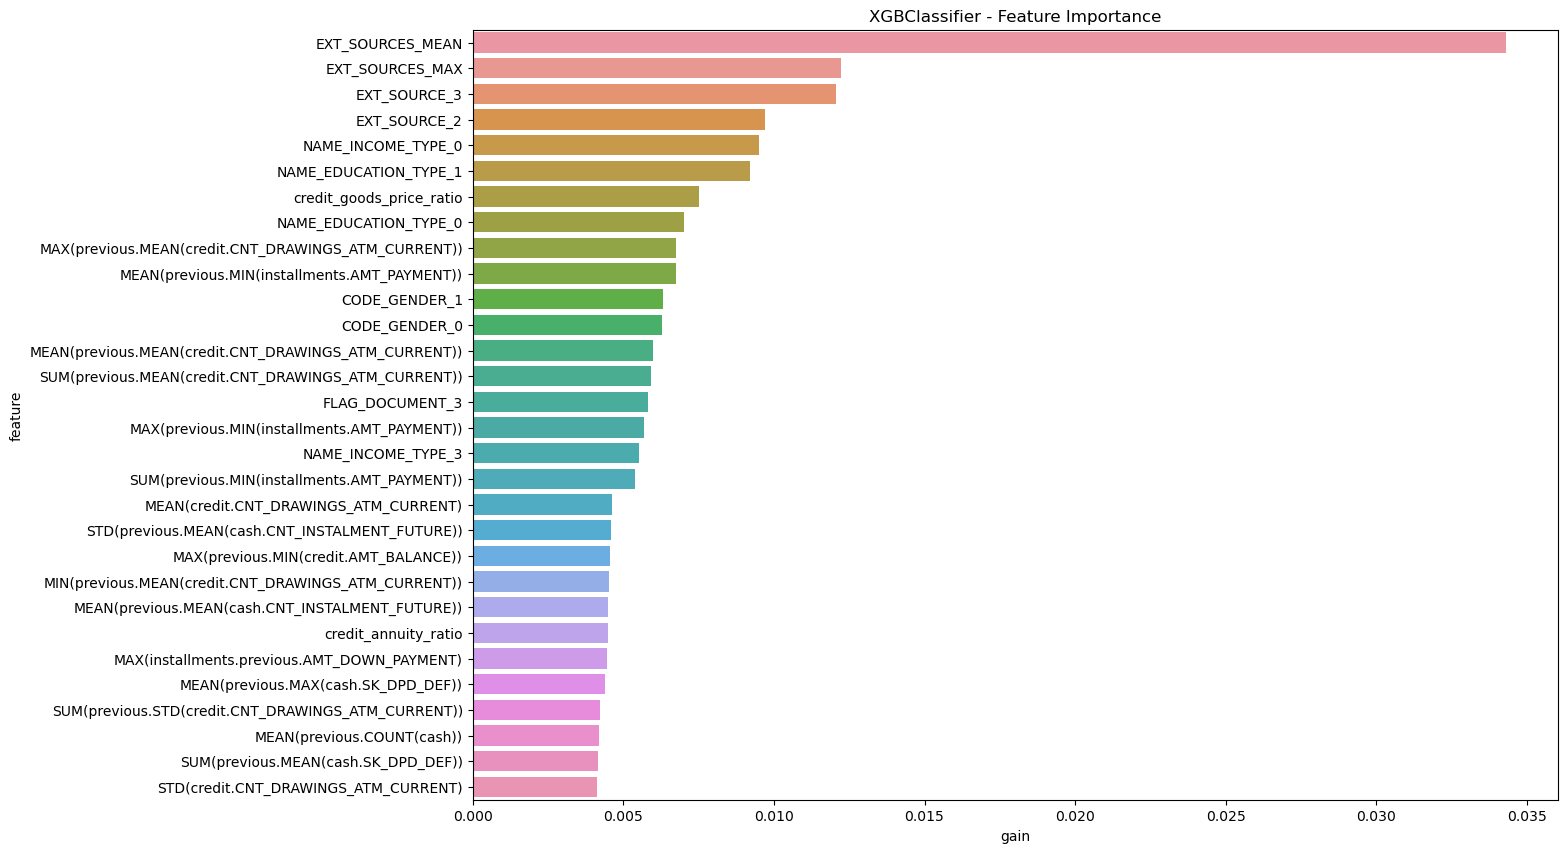

In [39]:
# plot top 30 feat_importance
plt.figure(figsize=(14, 10))
sns.barplot(
    x="gain",
    y="feature",
    data=feat_importance.sort_values(by="gain", ascending=False)[:30],
)
plt.title("XGBClassifier - Feature Importance")
plt.show()


## LGBM Finetuning

In [ ]:
from lightgbm import LGBMClassifier
from skopt import BayesSearchCV
from skopt.space import Real, Integer
from skopt.callbacks import DeltaYStopper
import time
import matplotlib.pyplot as plt
import numpy as np


class IterationTrackingCallback:
    def __init__(self):
        self.start_time = time.time()
        self.best_scores = []
        self.best_parameters = []

    def __call__(self, res):
        iteration_time = time.time() - self.start_time
        print(f"\nIteration completed in {iteration_time:.2f} seconds.")

        best_score_so_far = (
            -res.fun
        )  # Note: Depending on the scoring, you might need to negate this value
        self.best_scores.append(best_score_so_far)
        print(f"Best score so far: {best_score_so_far:.4f}")

        best_params_so_far = dict(zip(res.space.dimension_names, res.x))
        self.best_parameters.append(best_params_so_far)
        print("Best parameters so far:")
        for param_name, param_value in best_params_so_far.items():
            print(f"{param_name}: {param_value}")

        self.start_time = time.time()


# Assuming X_train and y_train are already defined

# Initialize the callback for LightGBM
iteration_callback_lgbm = IterationTrackingCallback()

# Define the LGBMClassifier
model_lgbm = LGBMClassifier(random_state=42, n_jobs=-1)

# Define the search space for LightGBM
search_spaces_lgbm = {
    "boosting_type": "goss",  # This is fixed based on your best parameters
    "n_estimators": Integer(9000, 11000),  # Centered around 10000
    "learning_rate": Real(0.001, 0.01, "log-uniform"),  # Centered around 0.005134
    "num_leaves": Integer(40, 70),  # Centered around 54
    "max_depth": Integer(8, 12),  # Centered around 10
    "reg_alpha": Real(0.2, 0.7),  # Centered around 0.436193
    "reg_lambda": Real(0.3, 0.65),  # Centered around 0.479169
    "colsample_bytree": Real(0.4, 0.6),  # Centered around 0.508716
    "min_split_gain": Real(0.01, 0.04),  # Centered around 0.024766
    "subsample": Real(0.8, 1.0),  # Fixed to 1 based on your parameters, might not need optimization
}

# Set up BayesSearchCV for LightGBM
opt_lgbm = BayesSearchCV(
    estimator=model_lgbm,
    search_spaces=search_spaces_lgbm,
    n_iter=30,
    scoring="roc_auc",
    cv=5,
    n_jobs=-1,
    return_train_score=True,
    refit=True,
    random_state=42,
)

# Fit the model
opt_lgbm.fit(X_train, y_train, callback=[iteration_callback_lgbm])

# Plot the improvement of scores over iterations for LightGBM
plt.figure(figsize=(10, 6))
plt.plot(iteration_callback_lgbm.best_scores, marker="o")
plt.title("Improvement of Best AUC Score over Iterations for LightGBM")
plt.xlabel("Iteration")
plt.ylabel("Best AUC Score")
plt.grid(True)
plt.show()

<img src="../images/LGBM_AUC_scores.png" alt="Alternative text" />


**LGBM Best params**
- Best score so far: 0.7839
- Best parameters so far:
- colsample_bytree: 0.7777705221999338
- learning_rate: 0.05131099661915068
- max_depth: 6
- min_child_weight: 2
- n_estimators: 300
- num_leaves: 30
- reg_alpha: 0.020319134025071888
- reg_lambda: 0.006022332321095017
- subsample: 0.9654145490108178

### LGBM Kfold

In [42]:
import numpy as np
import pandas as pd
from lightgbm import LGBMClassifier
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score
import gc

def kfold_lightgbm_sklearn(
    X_train,
    y_train,
    X_test=None,
    y_test=None,
    NUM_FOLDS=5,
    RANDOM_SEED=50,
    STRATIFIED_KFOLD=False,
    LGBM_PARAMS={}
):
    print(f"Train/valid shape: {X_train.shape, y_train.shape}")

    folds = StratifiedKFold(n_splits=NUM_FOLDS, shuffle=True, random_state=RANDOM_SEED) if STRATIFIED_KFOLD else KFold(n_splits=NUM_FOLDS, shuffle=True, random_state=RANDOM_SEED)

    oof_preds = np.zeros(X_train.shape[0])
    importance_df = pd.DataFrame()

    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X_train, y_train)):
        train_x, train_y = X_train.iloc[train_idx], y_train.iloc[train_idx]
        valid_x, valid_y = X_train.iloc[valid_idx], y_train.iloc[valid_idx]

        clf = LGBMClassifier(**LGBM_PARAMS, random_state=RANDOM_SEED, n_jobs=-1)
        clf.fit(
            train_x,
            train_y,
            eval_set=[(valid_x, valid_y)],
            eval_metric='auc',
            early_stopping_rounds=100,
            verbose=400,
            categorical_feature='auto'  # Auto-detect categorical features
        )

        proba_preds_valid = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)
        oof_preds[valid_idx] = proba_preds_valid[:, 1] if proba_preds_valid.shape[1] > 1 else proba_preds_valid[:, 0]

        fold_importance = pd.DataFrame(
            {
                "feature": train_x.columns.tolist(),
                "gain": clf.feature_importances_,
                "fold": n_fold + 1,
            }
        )
        importance_df = pd.concat([importance_df, fold_importance], axis=0)

        print("Fold %2d AUC : %.6f" % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
        gc.collect()

    print("Full AUC score %.6f" % roc_auc_score(y_train, oof_preds))

    if X_test is not None and y_test is not None:
        test_preds = clf.predict_proba(X_test, num_iteration=clf.best_iteration_)[:, 1]
        print("Test AUC score: %.6f" % roc_auc_score(y_test, test_preds))

    return (
        importance_df.groupby("feature")
        .gain.mean()
        .sort_values(ascending=False)
        .reset_index()
    )

# Define your LGBM_PARAMS
LIGHTGBM_PARAMS = {
    "boosting_type": "goss",
    "n_estimators": 10000,
    "learning_rate": 0.005134,
    "num_leaves": 54,
    "max_depth": 10,
    "subsample_for_bin": 240000,
    "reg_alpha": 0.436193,
    "reg_lambda": 0.479169,
    "colsample_bytree": 0.508716,
    "min_split_gain": 0.024766,
    "subsample": 1,
    "is_unbalance": False,
    "silent": -1,
    "verbose": -1,
}
feat_importance = kfold_lightgbm_sklearn(
    X_train,
    y_train,
    X_test,
    y_test,
    NUM_FOLDS=10,
    STRATIFIED_KFOLD=True,
    LGBM_PARAMS=LIGHTGBM_PARAMS,
)
print(feat_importance)


Train/valid shape: ((230633, 512), (230633, 1))
[400]	valid_0's auc: 0.760958	valid_0's binary_logloss: 0.248107
[800]	valid_0's auc: 0.769546	valid_0's binary_logloss: 0.243608
[1200]	valid_0's auc: 0.774625	valid_0's binary_logloss: 0.241745
[1600]	valid_0's auc: 0.77722	valid_0's binary_logloss: 0.240845
[2000]	valid_0's auc: 0.77852	valid_0's binary_logloss: 0.240421
[2400]	valid_0's auc: 0.779095	valid_0's binary_logloss: 0.240183
Fold  1 AUC : 0.779445
[400]	valid_0's auc: 0.754258	valid_0's binary_logloss: 0.248828
[800]	valid_0's auc: 0.764956	valid_0's binary_logloss: 0.244086
[1200]	valid_0's auc: 0.77076	valid_0's binary_logloss: 0.242205
[1600]	valid_0's auc: 0.773718	valid_0's binary_logloss: 0.241301
[2000]	valid_0's auc: 0.775552	valid_0's binary_logloss: 0.240747
[2400]	valid_0's auc: 0.776778	valid_0's binary_logloss: 0.240404
[2800]	valid_0's auc: 0.777564	valid_0's binary_logloss: 0.24018
[3200]	valid_0's auc: 0.778053	valid_0's binary_logloss: 0.240032
Fold  2 AUC :

- Full AUC score 0.786653
- Test AUC score: 0.785621

<Figure size 1400x1000 with 0 Axes>

<Axes: xlabel='gain', ylabel='feature'>

Text(0.5, 1.0, 'LGBM - Feature Importance')

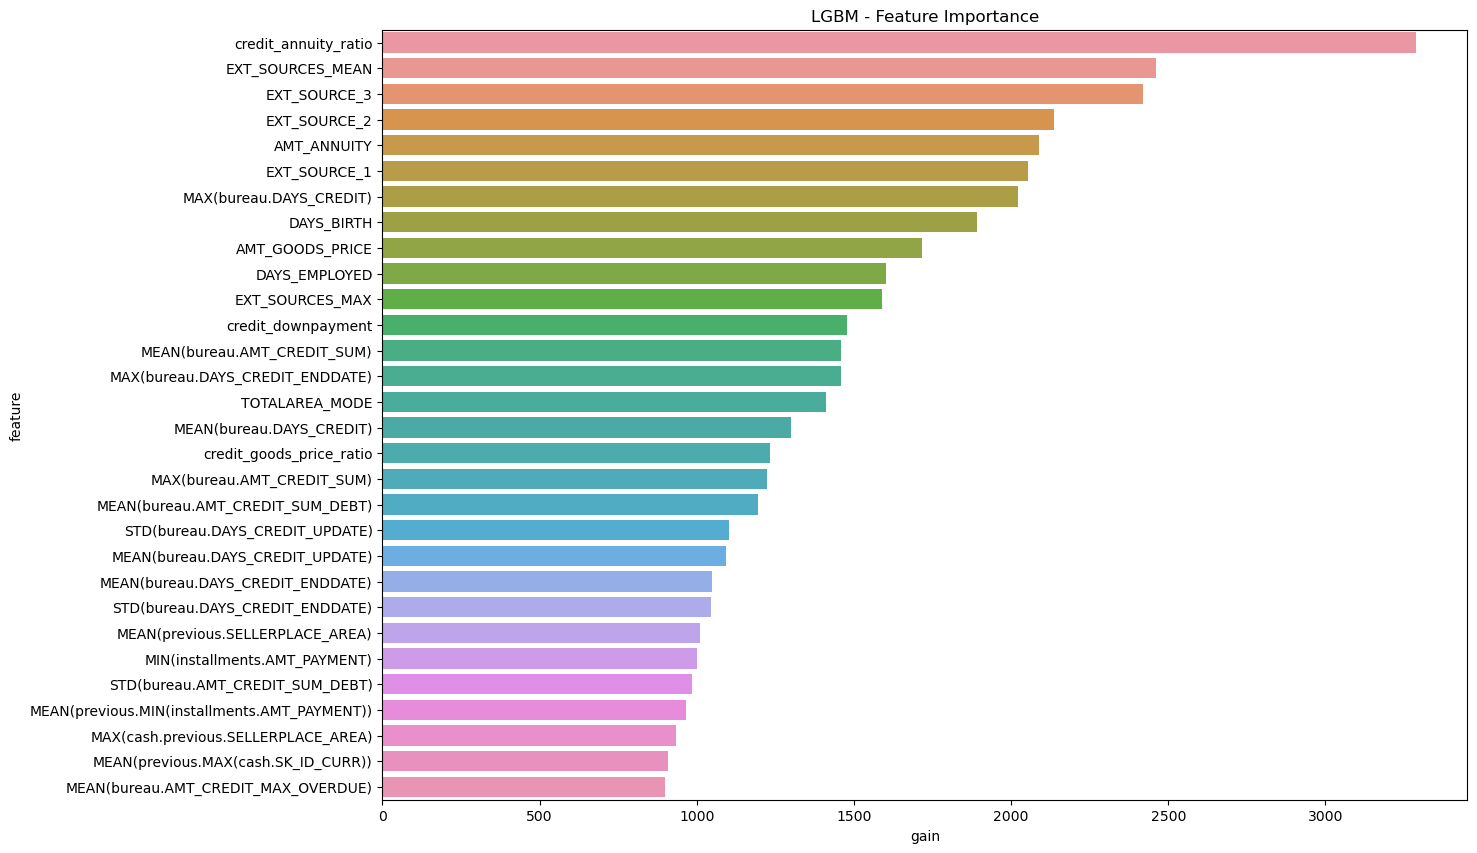

In [44]:
# plot top 30 feat_importance
plt.figure(figsize=(14, 10))
sns.barplot(
    x="gain",
    y="feature",
    data=feat_importance.sort_values(by="gain", ascending=False)[:30],
)
plt.title("LGBM - Feature Importance")
plt.show()


### CATBoost Finetune

In [ ]:
from catboost import CatBoostClassifier
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
import time
import matplotlib.pyplot as plt
import numpy as np


class IterationTrackingCallback:
    def __init__(self):
        self.start_time = time.time()
        self.best_scores = []
        self.best_parameters = []

    def __call__(self, res):
        iteration_time = time.time() - self.start_time
        print(f"\nIteration completed in {iteration_time:.2f} seconds.")

        best_score_so_far = (
            -res.fun
        )  # Note: Depending on the scoring, you might need to negate this value
        self.best_scores.append(best_score_so_far)
        print(f"Best score so far: {best_score_so_far:.4f}")

        best_params_so_far = dict(zip(res.space.dimension_names, res.x))
        self.best_parameters.append(best_params_so_far)
        print("Best parameters so far:")
        for param_name, param_value in best_params_so_far.items():
            print(f"{param_name}: {param_value}")

        self.start_time = time.time()


# Initialize the callback for CatBoost
iteration_callback_catboost = IterationTrackingCallback()

# Define the CatBoostClassifier
model_catboost = CatBoostClassifier(task_type="GPU", random_state=42, verbose=0)

# Define the search space for CatBoost
search_spaces_catboost = {
    "bootstrap_type": Categorical(["Bernoulli"]),  # Based on your best parameters
    "border_count": Integer(150, 250),  # Around 209
    "depth": Integer(4, 12),  # Around 6
    "iterations": Integer(300, 600),  # Around 450
    "l2_leaf_reg": Real(3, 10),  # Around 6.33
    "learning_rate": Real(0.05, 0.1),  # Around 0.0756
    "subsample": Real(0.8, 1.0),  # Around 0.929
}

# Set up BayesSearchCV for CatBoost
opt_catboost = BayesSearchCV(
    estimator=model_catboost,
    search_spaces=search_spaces_catboost,
    n_iter=30,
    scoring="roc_auc",
    cv=5,
    n_jobs=1,
    return_train_score=True,
    refit=True,
    random_state=42,
)

# Fit the model
opt_catboost.fit(X_train, y_train, callback=[iteration_callback_catboost])

# Plot the improvement of scores over iterations for CatBoost
plt.figure(figsize=(10, 6))
plt.plot(iteration_callback_catboost.best_scores, marker="o")
plt.title("Improvement of Best AUC Score over Iterations for CatBoost")
plt.xlabel("Iteration")
plt.ylabel("Best AUC Score")
plt.grid(True)
plt.show()

<img src="../images/CAT_AUC_scores.png" alt="Alternative text" />


**CATBOOST best params**
- Best score so far: 0.7845
- Best parameters so far:
- bootstrap_type: Bernoulli
- border_count: 192
- depth: 5
- iterations: 600
- l2_leaf_reg: 10.0
- learning_rate: 0.1
- subsample: 0.9933553655563268

### CATBoost Kfold

In [47]:
import numpy as np
import pandas as pd
from catboost import CatBoostClassifier
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score
import gc

def kfold_catboost_sklearn(
    X_train,
    y_train,
    cat_features,
    X_test=None,
    y_test=None,
    NUM_FOLDS=5,
    RANDOM_SEED=50,
    STRATIFIED_KFOLD=False,
    CATBOOST_PARAMS={}
):
    print(f"Train/valid shape: {X_train.shape, y_train.shape}")

    folds = StratifiedKFold(n_splits=NUM_FOLDS, shuffle=True, random_state=RANDOM_SEED) if STRATIFIED_KFOLD else KFold(n_splits=NUM_FOLDS, shuffle=True, random_state=RANDOM_SEED)

    oof_preds = np.zeros(X_train.shape[0])
    if X_test is not None:
        sub_preds = np.zeros(X_test.shape[0])
    importance_df = pd.DataFrame()

    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X_train, y_train)):
        train_x, train_y = X_train.iloc[train_idx], y_train.iloc[train_idx]
        valid_x, valid_y = X_train.iloc[valid_idx], y_train.iloc[valid_idx]

        clf = CatBoostClassifier(
            **CATBOOST_PARAMS,
            random_seed=RANDOM_SEED,
            cat_features=cat_features
        )
        clf.fit(
            train_x,
            train_y,
            eval_set=[(valid_x, valid_y)],
            verbose=400,
            early_stopping_rounds=100
        )

        proba_preds_valid = clf.predict_proba(valid_x)[:, 1]
        oof_preds[valid_idx] = proba_preds_valid

        if X_test is not None:
            sub_preds += clf.predict_proba(X_test)[:, 1] / folds.n_splits

        fold_importance = pd.DataFrame({
            "feature": train_x.columns.tolist(),
            "importance": clf.get_feature_importance(),
            "fold": n_fold + 1,
        })
        importance_df = pd.concat([importance_df, fold_importance], axis=0)

        print("Fold %2d AUC : %.6f" % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
        gc.collect()

    print("Full AUC score %.6f" % roc_auc_score(y_train, oof_preds))

    if X_test is not None and y_test is not None:
        print("Test AUC score: %.6f" % roc_auc_score(y_test, sub_preds))

    return (
        importance_df.groupby("feature")
        .importance.mean()
        .sort_values(ascending=False)
        .reset_index()
    )

# Example usage
cat_features = [index for index, col in enumerate(X_train.columns) if X_train[col].dtype == 'object']

CATBOOST_PARAMS = {
    'bootstrap_type': 'Bernoulli',
    'border_count': 192,
    'depth': 5,
    'iterations': 600,
    'l2_leaf_reg': 10.0,
    'learning_rate': 0.1,
    'subsample': 0.9933553655563268,
    'verbose': 0,
    'task_type': 'GPU',
    'devices': '0',
}

feat_importance = kfold_catboost_sklearn(
    X_train,
    y_train,
    cat_features,
    X_test,
    y_test,
    NUM_FOLDS=10,
    STRATIFIED_KFOLD=True,
    CATBOOST_PARAMS=CATBOOST_PARAMS
)
print(feat_importance)

Train/valid shape: ((230633, 512), (230633, 1))


0:	learn: 0.5895573	test: 0.5893566	best: 0.5893566 (0)	total: 10.9ms	remaining: 6.51s
400:	learn: 0.2267610	test: 0.2418065	best: 0.2417466 (389)	total: 4.37s	remaining: 2.17s
599:	learn: 0.2211305	test: 0.2414730	best: 0.2414618 (597)	total: 6.54s	remaining: 0us
bestTest = 0.2414617681
bestIteration = 597
Shrink model to first 598 iterations.
Fold  1 AUC : 0.775590
0:	learn: 0.5895238	test: 0.5896692	best: 0.5896692 (0)	total: 11ms	remaining: 6.56s
400:	learn: 0.2268121	test: 0.2418718	best: 0.2418524 (396)	total: 4.37s	remaining: 2.17s
bestTest = 0.2418524312
bestIteration = 396
Shrink model to first 397 iterations.
Fold  2 AUC : 0.772663
0:	learn: 0.5895999	test: 0.5896525	best: 0.5896525 (0)	total: 10.8ms	remaining: 6.47s
400:	learn: 0.2268746	test: 0.2377871	best: 0.2377269 (379)	total: 4.43s	remaining: 2.2s
bestTest = 0.2377269373
bestIteration = 379
Shrink model to first 380 iterations.
Fold  3 AUC : 0.786059
0:	learn: 0.5895069	test: 0.5897683	best: 0.5897683 (0)	total: 11ms	r

- Full AUC score 0.783144
- Test AUC score: 0.785359

<Figure size 1400x1000 with 0 Axes>

<Axes: xlabel='importance', ylabel='feature'>

Text(0.5, 1.0, 'CATBoost - Feature Importance')

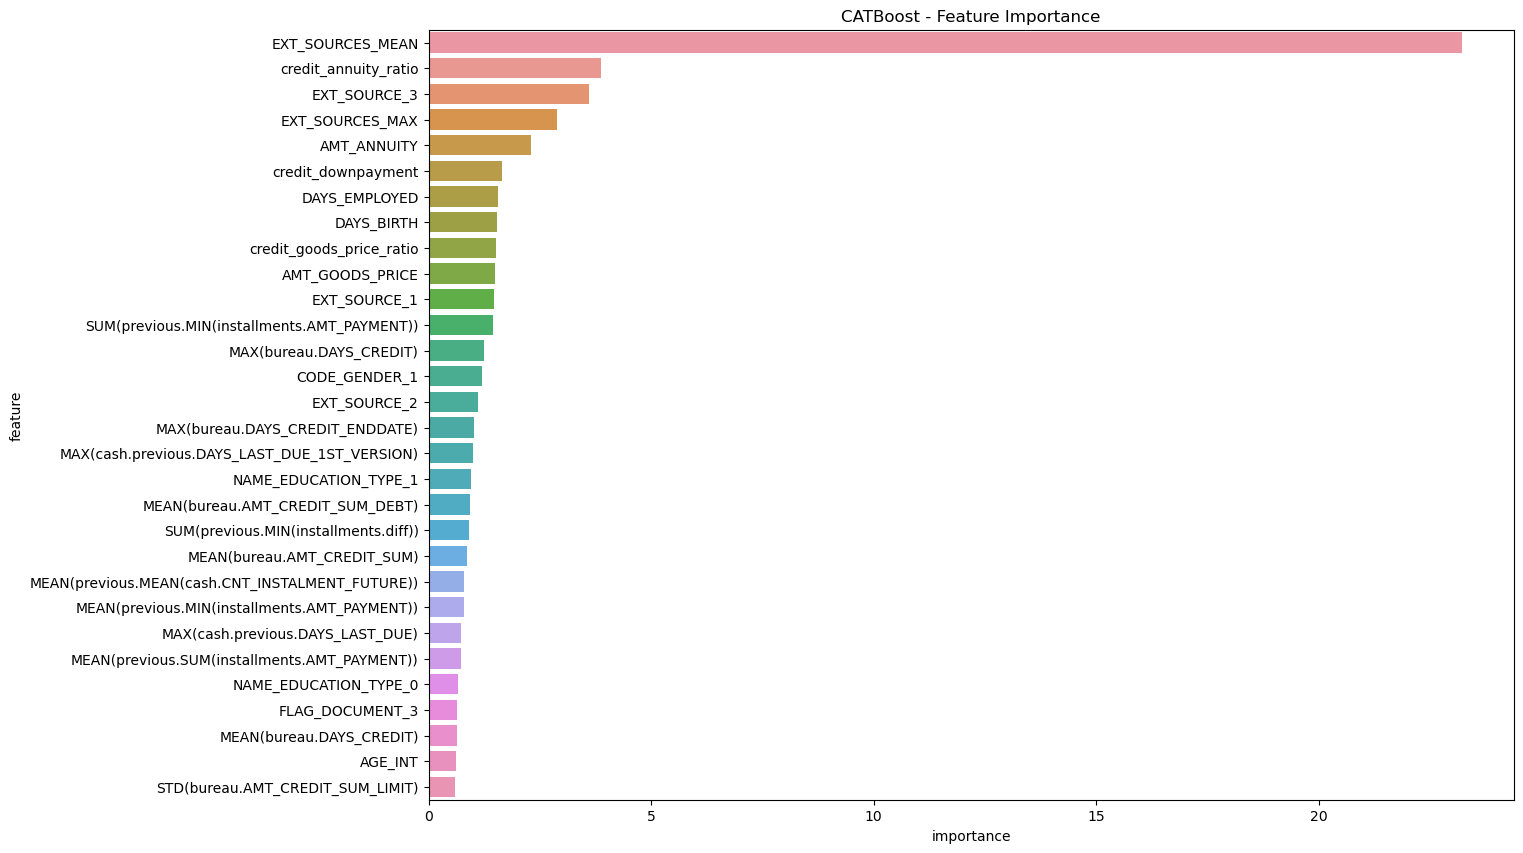

In [50]:
# plot top 30 feat_importance
plt.figure(figsize=(14, 10))
sns.barplot(
    x="importance",
    y="feature",
    data=feat_importance.sort_values(by="importance", ascending=False)[:30],
)
plt.title("CATBoost - Feature Importance")
plt.show()


### RF Finetune


Iteration completed in 90.05 seconds.
Best score so far: 0.7454
Best parameters so far:
max_depth: 10
max_features: log2
min_samples_leaf: 6
min_samples_split: 5
n_estimators: 301

Iteration completed in 137.00 seconds.
Best score so far: 0.7488
Best parameters so far:
max_depth: 14
max_features: log2
min_samples_leaf: 3
min_samples_split: 10
n_estimators: 359

Iteration completed in 49.37 seconds.
Best score so far: 0.7488
Best parameters so far:
max_depth: 14
max_features: log2
min_samples_leaf: 3
min_samples_split: 10
n_estimators: 359

Iteration completed in 225.73 seconds.
Best score so far: 0.7557
Best parameters so far:
max_depth: 14
max_features: sqrt
min_samples_leaf: 4
min_samples_split: 8
n_estimators: 257

Iteration completed in 322.58 seconds.
Best score so far: 0.7562
Best parameters so far:
max_depth: 14
max_features: sqrt
min_samples_leaf: 4
min_samples_split: 8
n_estimators: 371

Iteration completed in 123.97 seconds.
Best score so far: 0.7562
Best parameters so far:


BayesSearchCV(cv=5,
              estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
              n_iter=15, random_state=42, return_train_score=True,
              scoring='roc_auc',
              search_spaces={'max_depth': Integer(low=5, high=16, prior='uniform', transform='normalize'),
                             'max_features': Categorical(categories=('sqrt', 'log2'), prior=None),
                             'min_samples_leaf': Integer(low=1, high=6, prior='uniform', transform='normalize'),
                             'min_samples_split': Integer(low=2, high=10, prior='uniform', transform='normalize'),
                             'n_estimators': Integer(low=100, high=400, prior='uniform', transform='normalize')})

<Figure size 1000x600 with 0 Axes>

Text(0.5, 1.0, 'Improvement of Best AUC Score over Iterations for Random Forest')

Text(0.5, 0, 'Iteration')

Text(0, 0.5, 'Best AUC Score')

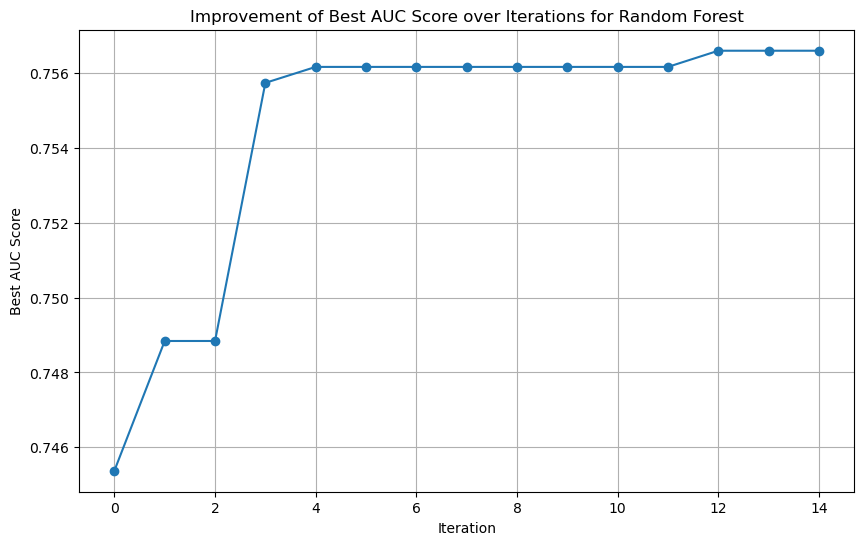

In [34]:
from sklearn.ensemble import RandomForestClassifier
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
import time
import matplotlib.pyplot as plt
import numpy as np


class IterationTrackingCallback:
    def __init__(self):
        self.start_time = time.time()
        self.best_scores = []
        self.best_parameters = []

    def __call__(self, res):
        iteration_time = time.time() - self.start_time
        print(f"\nIteration completed in {iteration_time:.2f} seconds.")

        best_score_so_far = -res.fun  # Assuming we are maximizing AUC
        self.best_scores.append(best_score_so_far)
        print(f"Best score so far: {best_score_so_far:.4f}")

        best_params_so_far = dict(zip(res.space.dimension_names, res.x))
        self.best_parameters.append(best_params_so_far)
        print("Best parameters so far:")
        for param_name, param_value in best_params_so_far.items():
            print(f"{param_name}: {param_value}")

        self.start_time = time.time()


# Initialize the callback for Random Forest
iteration_callback_rf = IterationTrackingCallback()

# Define the RandomForestClassifier
model_rf = RandomForestClassifier(random_state=42, n_jobs=-1)

# Define the search space for RandomForest
search_spaces_rf = {
    "n_estimators": Integer(100, 400),  # Number of trees
    "max_depth": Integer(5, 16),  # Depth of each tree
    "min_samples_split": Integer(
        2, 10
    ),  # Minimum number of samples required to split an internal node
    "min_samples_leaf": Integer(
        1, 6
    ),  # Minimum number of samples required to be at a leaf node
    "max_features": Categorical(["sqrt", "log2"]),
}

# Set up BayesSearchCV for Random Forest
opt_rf = BayesSearchCV(
    estimator=model_rf,
    search_spaces=search_spaces_rf,
    n_iter=15,
    scoring="roc_auc",
    cv=5,
    n_jobs=1,  # Use -1 for all CPUs
    return_train_score=True,
    refit=True,
    random_state=42,
)

# Fit the model
opt_rf.fit(X_train, y_train, callback=[iteration_callback_rf])

# Plot the improvement of scores over iterations for Random Forest
plt.figure(figsize=(10, 6))
plt.plot(iteration_callback_rf.best_scores, marker="o")
plt.title("Improvement of Best AUC Score over Iterations for Random Forest")
plt.xlabel("Iteration")
plt.ylabel("Best AUC Score")
plt.grid(True)
plt.show()

<img src="../images/RF_AUC_scores.png" alt="Alternative text" />


**RF Best Params** :
**0.7566**

Best parameters so far:
- max_depth: 16
- max_features: sqrt
- min_samples_leaf: 6
- min_samples_split: 10
- n_estimators: 397

Fit all the models with the best parameters

In [52]:
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
# Define models with names
models = {
    "LGBM": LGBMClassifier(
        boosting_type="goss",
        n_estimators=10000,
        learning_rate=0.005134,
        num_leaves=54,
        max_depth=10,
        subsample_for_bin=240000,
        reg_alpha=0.436193,
        reg_lambda=0.479169,
        colsample_bytree=0.508716,
        min_split_gain=0.024766,
        subsample=1,
        is_unbalance=False,
        silent=-1,
        verbose=-1,
    ),
    "CatBoost": CatBoostClassifier(
        bootstrap_type="Bernoulli",
        border_count=192,
        depth=5,
        iterations=600,
        l2_leaf_reg=10.0,
        learning_rate=0.1,
        subsample=0.9933553655563268,
        verbose=0,
        task_type="GPU",
        devices="0",
        random_state=42,
    ),
    "XGB": XGBClassifier(
        colsample_bylevel=0.7,
        colsample_bynode=1.0,
        colsample_bytree=0.7,
        gamma=5,
        learning_rate=0.08807219785563987,
        max_depth=4,
        min_child_weight=3,
        n_estimators=300,
        reg_alpha=1e-05,
        reg_lambda=1.0,
        subsample=0.85,
        use_label_encoder=False,
        eval_metric="logloss",
        random_state=42,
        tree_method="gpu_hist",
    ),
}

fitted_models = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    fitted_models[name] = model

print("Models have been fitted.")

LGBMClassifier(boosting_type='goss', colsample_bytree=0.508716,
               is_unbalance=False, learning_rate=0.005134, max_depth=10,
               min_split_gain=0.024766, n_estimators=10000, num_leaves=54,
               reg_alpha=0.436193, reg_lambda=0.479169, silent=-1, subsample=1,
               subsample_for_bin=240000, verbose=-1)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=0.7, colsample_bynode=1.0, colsample_bytree=0.7,
              device=None, early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None, gamma=5,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.08807219785563987,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

Models have been fitted.


In [53]:
# Save all of the fitted models
import joblib

# Save the fitted models to disk
for name, model in fitted_models.items():
    joblib.dump(model, f'../models/{name}_finetuned.joblib')

model_names = ["LGBM", "CatBoost", "XGB"]

# Load each model from the saved .joblib files
for name in model_names:
    fitted_models[name] = joblib.load(f"../models/{name}_finetuned.joblib")

['../models/LGBM_finetuned.joblib']

['../models/CatBoost_finetuned.joblib']

['../models/XGB_finetuned.joblib']

Confusion matrix

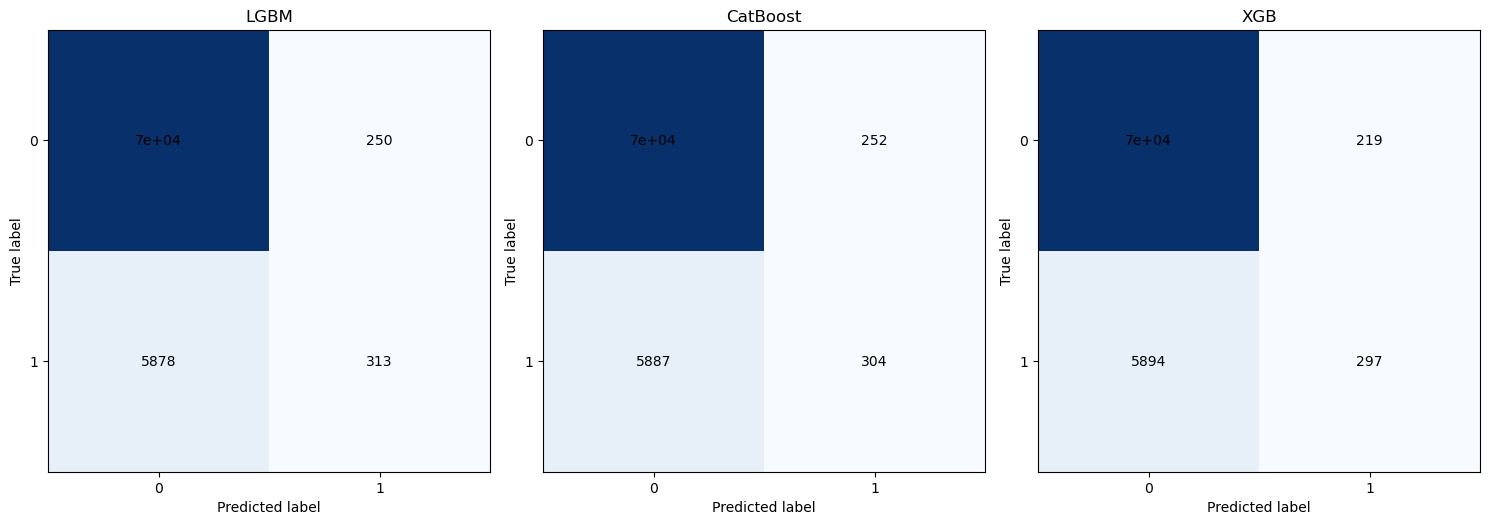

In [55]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Placeholder for confusion matrix plots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 20))
for ax, (name, model) in zip(axes.flatten(), fitted_models.items()):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=ax, colorbar=False)  # Turn off the colorbar
    ax.title.set_text(name)
    disp.im_.set_cmap("Blues")  # Set the colormap to 'Blues' or any other colormap

    # Change the color of the text in the confusion matrix
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            disp.text_[i, j].set_color(
                "black"
            )  # Change 'yellow' to your color of choice

plt.tight_layout()
plt.show()

Feature Importances

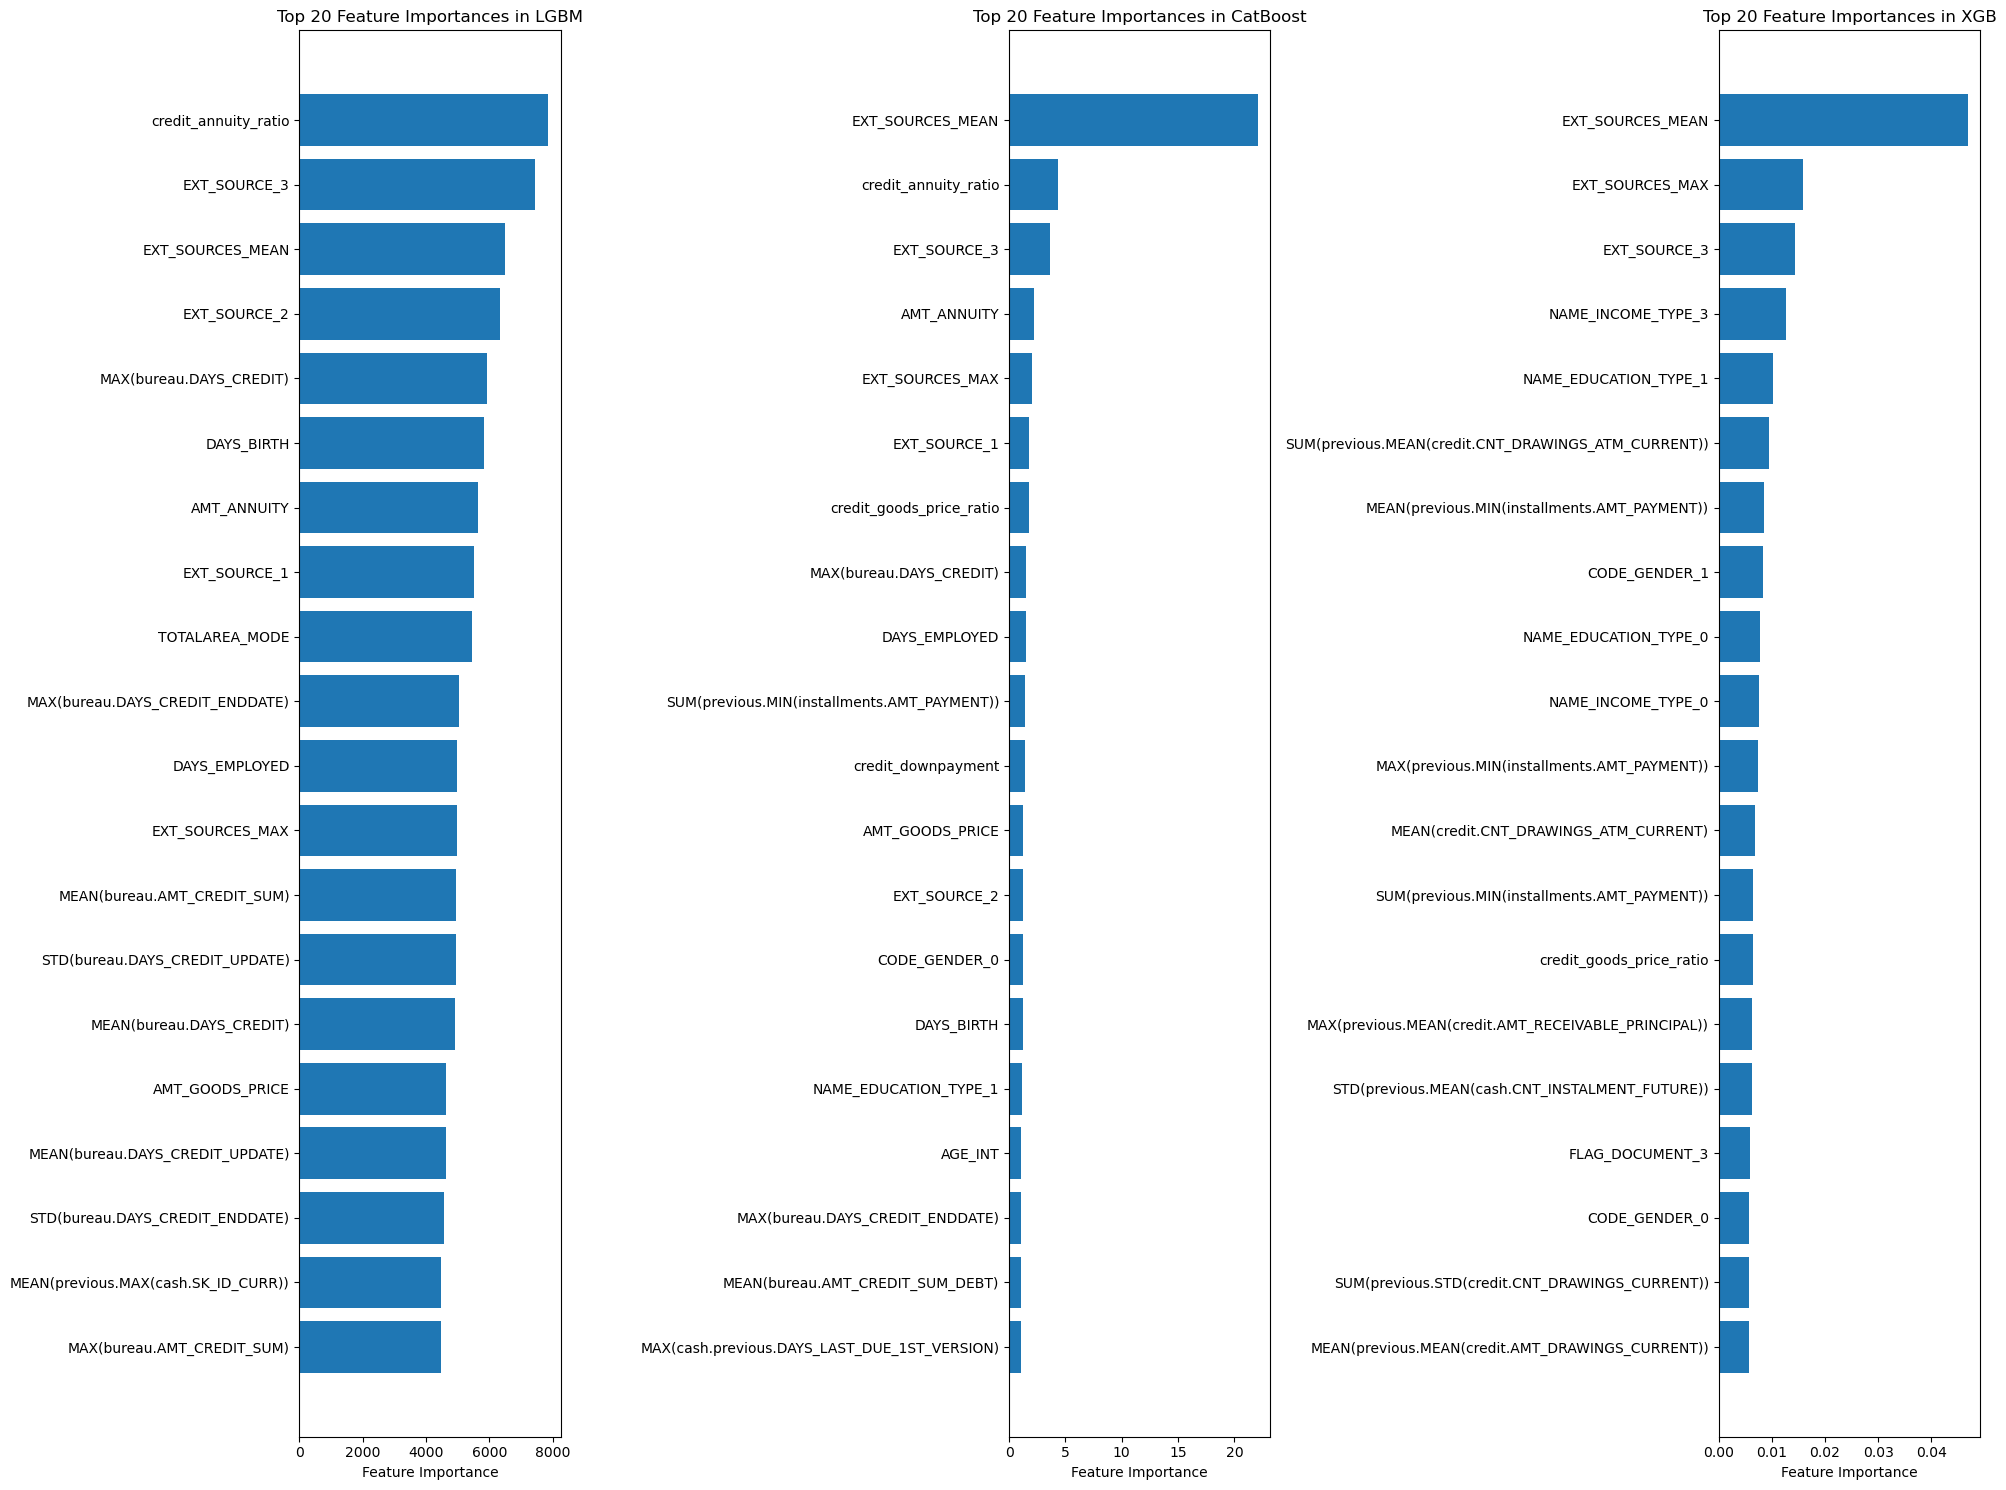

In [57]:
# Assuming X_train is a DataFrame that includes feature names as columns
feature_names = X_train.columns

# Plotting feature importances for each model
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 15))
for ax, (name, model) in zip(axes.flatten(), fitted_models.items()):
    # Check if the model has 'feature_importances_'
    if hasattr(model, "feature_importances_"):
        # Get feature importances
        importances = model.feature_importances_
        # Indices of top 20 features
        indices = np.argsort(importances)[-20:]
        # Bar plot for feature importances
        ax.barh(range(len(indices)), importances[indices], align="center")
        # Set the y-ticks to be the feature names
        ax.set_yticks(range(len(indices)))
        ax.set_yticklabels([feature_names[i] for i in indices])
        ax.set_xlabel("Feature Importance")
        ax.set_title(f"Top 20 Feature Importances in {name}")
    else:
        ax.set_title(f"{name} does not support feature importances")
        ax.axis("off")

plt.tight_layout()
plt.show();

## Blending Fine-tuned Models

In [79]:
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score

X_blend_train, X_blend_test, y_blend_train, y_blend_test = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

n_models = len(fitted_models)
predictions = np.zeros((X_blend_test.shape[0], n_models))

for name, model in (models.items()):
    print(model.__class__.__name__)
    # Randomly select half of the features for each model to train on
    random_features = np.random.choice(
        X_blend_train.columns, size=len(X_blend_train.columns) // 2, replace=False
    )

    # Train the model on these features
    model.fit(X_blend_train[random_features], y_blend_train)

    # Predict on the test set
    predictions[:, i] = model.predict_proba(X_blend_test[random_features])[:, 1]

# Average the predictions
final_blend_predictions = np.mean(predictions, axis=1)

# Evaluate (Example using AUC)
print(f"Blended Model AUC: {roc_auc_score(y_blend_test, final_blend_predictions)}")

LGBMClassifier


LGBMClassifier(boosting_type='goss', colsample_bytree=0.508716,
               is_unbalance=False, learning_rate=0.005134, max_depth=10,
               min_split_gain=0.024766, n_estimators=10000, num_leaves=54,
               reg_alpha=0.436193, reg_lambda=0.479169, silent=-1, subsample=1,
               subsample_for_bin=240000, verbose=-1)

CatBoostClassifier


XGBClassifier


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=0.7, colsample_bynode=1.0, colsample_bytree=0.7,
              device=None, early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None, gamma=5,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.08807219785563987,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

Blended Model AUC: 0.7755652793814815
